In [71]:
import pandas as pd
import numpy as np
from matplotlib as plt
from pprint import pprint
import pickle
%matplotlib inline

In [2]:
# movie_data = pickle.load( open( "movie_data.pkl", "rb" ) )

maybe need to through out movies that are currently in theatres, because this data wont be accurate for those data points

In [173]:

movie_keys = ['title','domestic_total', 'runtime','rating', 'release_date' ]
weekly_keys = ['rank','num_theaters','weekly_gross', 'week_num']

In [195]:
def parse_value(num):
    try:
        num = int(num.replace('$', '').replace(',', ''))
    except:
        num = np.nan
    return num
    

In [196]:
def parse_weekly_data(weekly_dict):
    '''a function that creates the attributes that are a function 
       of the weekly data (e.g., drop_off_rate) and others. Minimum case yields
       the number of weeks in theatres.
    '''
    weeks = {}
    weekly_keys = ['rank','num_theaters','weekly_gross', 'week_num']
    for key in weekly_keys:
        weeks[key] = [parse_value(x) for x in weekly_dict[key]]
    return weeks

In [210]:
def parse_movie_data(movie_data):
    ''' Takes a dict of a movie scraped from Box Office Mojo and generates
        a row of for each feature to be added to the dataframe.
    '''
    mvp_movie_data = []
    for movie_dict in movie_data:
        # Only keep movies with correct initial values.
        if '1' == movie_dict['weekly_data']['week_num'][0]:
            movie = [movie_dict[key] for key in movie_keys]
            movie.append(max([int(x) for x in movie_dict['weekly_data']['week_num']]))
            movie.append(parse_weekly_data(movie_dict['weekly_data']))
            mvp_movie_data.append(movie) 
    return pd.DataFrame(mvp_movie_data)

In [211]:
df = parse_movie_data(movie_data)

Subsetted the data set to only include movies with data that started at week 1!

In [213]:
names = movie_keys + ['num_weeks','weekly_data']
df.columns = names

Subset set df so that every movie ran for at least 2 weeks, otherwise, there would be nothing to predict for movies that ended in the first week. 

In [214]:
df = df[df['num_weeks']>2]

In [215]:
df.head()

,title,domestic_total,runtime,rating,release_date,num_weeks,weekly_data
0,The A-Team,77222099,117,PG-13,2010-06-11,14,"{u'weekly_gross': [36022270, 20820708, 9247972..."
1,A.C.O.D.,175705,88,PG-13,2013-10-04,5,"{u'weekly_gross': [26439, 48909, 64916, 24656,..."
2,A.I. Artificial Intelligence,78616689,145,PG-13,2001-06-29,11,"{u'weekly_gross': [45535716, 19346848, 7471014..."
3,Aaja Nachle,484108,145,Unrated,2007-11-30,3,"{u'weekly_gross': [310893, 132908, 40307], u'n..."
4,Aarakshan,651096,NaN,Unrated,2011-08-12,6,"{u'weekly_gross': [440710, 159031, 39141, 1011..."


In [268]:
def get_features(df,current_week_num):
    ''' This function takes the main dataframe and a current week number and
        dynamically generates the full feature set by parsing the weekly data dict.
    '''
    new_data = []
    current_week_num = 1
    x = df[df['num_weeks']>current_week_num]
    for row in x.as_matrix():
        new_vals = [vals[current_week_num -1 ] for vals in row[6].values()]
        new_data.append(new_vals)
    d = pd.DataFrame(new_data)
    names = [s + str(current_week_num) for s in row[6].keys()]
    d.columns = names
    features = pd.concat([x, d], axis=1)
    return features

In [270]:
X = get_features(df,1)

In [272]:
X.head(10)

,title,domestic_total,runtime,rating,release_date,num_weeks,weekly_data,weekly_gross1,num_theaters1,rank1,week_num1
0,The A-Team,77222099,117,PG-13,2010-06-11,14,"{u'weekly_gross': [36022270, 20820708, 9247972...",36022270,3535,2,1
1,A.C.O.D.,175705,88,PG-13,2013-10-04,5,"{u'weekly_gross': [26439, 48909, 64916, 24656,...",26439,3,61,1
2,A.I. Artificial Intelligence,78616689,145,PG-13,2001-06-29,11,"{u'weekly_gross': [45535716, 19346848, 7471014...",45535716,3242,1,1
3,Aaja Nachle,484108,145,Unrated,2007-11-30,3,"{u'weekly_gross': [310893, 132908, 40307], u'n...",310893,66,24,1
4,Aarakshan,651096,NaN,Unrated,2011-08-12,6,"{u'weekly_gross': [440710, 159031, 39141, 1011...",440710,90,26,1
5,Aatsinki: The Story of Arctic Cowboys,6601,85,Unrated,2014-01-24,6,"{u'weekly_gross': [5359, 1242], u'num_theaters...",5359,1,73,1
6,Abandon,10727683,99,PG-13,2002-10-18,9,"{u'weekly_gross': [6023852, 2919275, 1149922, ...",6023852,2341,7,1
7,NaN,NaN,NaN,NaN,NaT,NaN,NaN,126154,25,NaN,1
8,ABCD,222098,145,Unrated,2013-02-08,4,"{u'weekly_gross': [126154, 76711, 18176, 1057]...",614396,146,15,1
9,ABCD,892133,154,Unrated,2015-06-19,4,"{u'weekly_gross': [614396, 227713, 40239, 9785...",4944,17,90,1


In [225]:


print [x[0] for x in df.loc[0].weekly_data.values()]

[36022270, 3535, 2, 1]


In [142]:
bins = [i*5 for i in range(12)]

In [145]:
print [len(df[df['num_weeks']>n]) for n in bins]
print bins

[7063, 4843, 2626, 1218, 491, 178, 73, 28, 13, 7, 0, 0]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]


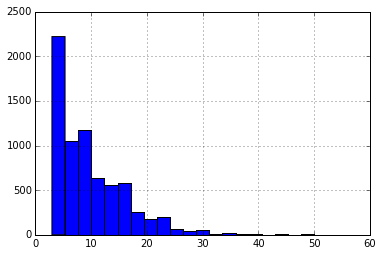

In [209]:
df.num_weeks.hist(bins=20)

this is how you can parse the dollar amounts

In [146]:
# [int(x.replace('$', '').replace(',', '')) for x in test[0]['weekly_data']['weekly_gross']]